# Compare different methods for coordinate linking

## simulate videos to test methods' performance

### hard spheres simulation
##### we use steepest descent with a modified LJ potential to make sure objects don't overlap

In [89]:
def steepest_descent(pos, gamma=0.01, maxstep=0.001, radius = 5, epsilon=1, DIM = 2, BoxSize = 512):
    sigma = 2* radius
    Rcutoff = (2**(1/6))*sigma
    phicutoff = -epsilon
    N = pos.shape[0]
    acc = np.zeros((N,DIM))
    for i in range(N-1):
        for j in range(i+1,N): #i+1 to N ensures we do not double count
            Sij = pos[i,:]-pos[j,:] # Distance in box scaled units
            for l in range(DIM): # Periodic interactions
                if (np.abs(Sij[l])>0.5):
                    Sij[l] = Sij[l] - np.copysign(1.0,Sij[l]) # If distance is greater than 0.5  (scaled units) then subtract 0.5 to find periodic interaction distance.
            
            Rij = BoxSize*Sij # Scale the box to the real units in this case reduced LJ units
            Rsqij = np.dot(Rij,Rij) # Calculate the square of the distance
            
            if(Rsqij < Rcutoff**2):
                # Calculate LJ potential inside cutoff
                # We calculate parts of the LJ potential at a time to improve the efficieny of the computation (most important for compiled code)
                rm2 = (sigma**2)/Rsqij # 1/r^2
                rm6 = rm2**3.0 # 1/r^6
                rm12 = rm6**2.0 # 1/r^12
                phi = epsilon*(4.0*(rm12-rm6))-phicutoff # 4[1/r^12 - 1/r^6] - phi(Rc) - we are using the shifted LJ potential
                # The following is dphi = -(1/r)(dV/dr)
                dphi = epsilon*24.0*rm2*(2.0*rm12-rm6) # 24[2/r^14 - 1/r^8]
                acc[i,:] = acc[i,:]+dphi*Sij # Accumulate forces
                acc[j,:] = acc[j,:]-dphi*Sij # (Fji=-Fij)

    pos = pos + np.sign(acc)*np.minimum(np.abs(gamma*acc), maxstep ) # Step 1
    fmax = np.max(np.sum(acc**2, axis=1))


    for i in range(DIM):
        pos[:,i]=(pos[:,i]+0.5) % 1. - 0.5
            
    return pos, fmax

### function to simulate random particle positions and apply steepest descent

In [90]:
def generate_centroids(num_of_particles = [20,21],  BoxSize = 512, DIM = 2, show = False, radius = 5):

    N = np.random.randint(*num_of_particles)

    # initialize positions
    pos = np.random.uniform(-BoxSize/2,BoxSize/2,[N,DIM]) 
    pos = pos[:,:DIM]/BoxSize
    fmax = 1e10
    while fmax>1e2:
        pos,fmax = steepest_descent(pos, gamma=0.05, maxstep=0.01, radius = radius, epsilon=1, DIM = DIM, BoxSize = BoxSize )
        if show == True:
            from IPython import display
            plt.cla()
            plt.xlim(-0.6*BoxSize,0.6*BoxSize)
            plt.ylim(-0.6*BoxSize,0.6*BoxSize)
            for i in range(N):
                c=plt.Circle((pos[i,0]*BoxSize,pos[i,1]*BoxSize), radius=radius, linewidth=1, color='blue', fill=False)
                plt.gca().add_patch(c)
                plt.gca().set_aspect('equal', adjustable='box')
            display.clear_output(wait=True)
            display.display(plt.gcf())
    pos = pos[:,:DIM]*BoxSize + BoxSize/2
    return pos

### Simulation of particle dynamics
#### Vicsek model with volume exclusion through steepest descent (adapted from https://github.com/softmatterlab/SOCS/tree/main/Chapter_08_Vicsek_Model)

In [91]:
import numpy as np 
from numpy import arctan2 as atan2, sin, cos
   
def simulate_Vicsek(n=10,N=30,dt=0.03,R=10,l=100,V=20):
    in_pos = generate_centroids(num_of_particles = [n, n+1],radius= R, show=False, BoxSize=2*l)

    pos=np.empty([n,2])

    pos[:,0] = in_pos[:,0] % (2*l) - l    # x coordinates  ##np.random.rand(n)*2*l - l    # x coordinates            
    pos[:,1] = in_pos[:,1] % (2*l) - l   # y coordinates  ##np.random.rand(n)*2*l - l    # y coordinates  
    phi = np.random.rand(n)*2*np.pi  # orientations                # Initialization 

    trajs_gt=np.empty([N,n,2+1])

    for j in range(n):
        trajs_gt[0,j,0]=pos[j,0]+l
        trajs_gt[0,j,1]=pos[j,1]+l
        trajs_gt[0,j,2]=0

    for i in range(N-1):
        rad = 2.5*R
        Dr = 0.1
    
        pos[:,0] = (pos[:,0] + V*cos(phi)*dt +l) % (2*l) - l    # Update x coordinates
        pos[:,1] = (pos[:,1] + V*sin(phi)*dt +l) % (2*l) - l    # Update y coordinates

        fmax = 1e10

        while fmax>1e2:
            pos,fmax = steepest_descent(pos/(2*l), gamma=0.01, maxstep=0.001, radius = R, epsilon=1, DIM = 2, BoxSize = 2*l )
    
        pos[:,0] = pos[:,0]*2*l
        pos[:,1] = pos[:,1]*2*l

        for j in range(n):
            distances = np.sqrt((pos[:,0]-pos[j,0])**2 + (pos[:,1]-pos[j,1])**2)      # Calculate distances array to the particle       
            interact = distances < rad                          # Create interaction indices 
            phi[j] = np.angle(np.sum(np.exp(phi[interact]*1j))) + Dr * np.random.randn()                                   # Update orientations

            trajs_gt[i+1,j,0]=pos[j,0]+l
            trajs_gt[i+1,j,1]=pos[j,1]+l
            trajs_gt[i+1,j,2]=i+1
        
    return trajs_gt

#### run simulation

In [92]:
# Parameters of the simulation
n = 10 # number of particles
N = 10  # Simulation time
dt = 0.03   # Time step 
R = 10 # particle radius

# Physical parameters of the system 
l = 100        # half box size
V = 20         # Particle velocity 

trajs_gt = simulate_Vicsek(n=n,N=N,dt=dt,R=R,l=l,V=V)

#### break trajectories exiting/entering the FOV and make trajectory list

In [93]:
# make list 
def traj_break(trajs_gt):
    trajs_gt_list=[]
    trajs_gt_n = trajs_gt[:,:,[2, 0, 1]] #swap axes, frame first
    for j in range(n):
        dx = np.abs(trajs_gt[1:,j,0]-trajs_gt[:-1,j,0])
        dy = np.abs(trajs_gt[1:,j,1]-trajs_gt[:-1,j,1])
        ind = np.where((dx > 1.5*l) | (dy > 1.5*l))[0]
        ind = list(np.unique((-1 , len(dx)+1, *ind)))
        for k in range(len(ind)-1):
            trajs_gt_list.append(trajs_gt_n[ind[k]+1:ind[k+1],j,:])
    return trajs_gt_list


trajs_gt_list = traj_break(trajs_gt)

#### utility to convert movies to 8-bit

In [94]:
def convert_uint8(mov):

    new_mov = []
    for idx_im, im in enumerate(mov):
        im = im[:,:,0]
        im = im / im.max()
        im = im * 255
        im = im.astype(np.uint8)
        new_mov.append(im)
    return new_mov

### function to generate simulated images/videos from coordinates

In [95]:
import imageio

def transform_to_video(
    trajectory_data,
    particle_props={},
    optics_props={},
    background_props={},
    IMAGE_SIZE = [],
    save_video=False,
    maps = True,
    path="",
):
    
    _particle_dict = {
        "z": 0,  # Particles are always at focus
        "position_unit": "pixel",
    }
        
    _optics_dict = {
        "NA": 1.4,  # Numerical aperture
        "wavelength": 633. * dt.units.nm,  # Wavelength
        "refractive_index_medium": 1.33,
        "output_region": [0, 0, IMAGE_SIZE, IMAGE_SIZE],
        "magnification": 1,
        "resolution": 100* dt.units.nm,  # Wavelength,  # Camera resolution or effective resolution
    }

    _optics2_dict = {
        "NA": 1.9,  # Numerical aperture
        "wavelength": 300. * dt.units.nm,  # Wavelength
        "refractive_index_medium": 1.33,
        "output_region": [0, 0, 4*IMAGE_SIZE, 4*IMAGE_SIZE],
        "magnification": 4,
        "resolution": 25* dt.units.nm,  # Wavelength,  # Camera resolution or effective resolution
    }

    # Background offset
    _background_dict = {
        "background_mean": 85,  # Mean background intensity
        "background_std": 0,  # Standard deviation of background intensity within a video
    }
    
    # Update the dictionaries with the user-defined values
    _particle_dict.update(particle_props)
    _optics_dict.update(optics_props)
    _optics2_dict.update(optics_props)
    _background_dict.update(background_props)


    # Reshape the trajectory
    trajectory_data = np.moveaxis(trajectory_data, 0, 1)

    inner_sphere = dt.Sphere(
        trajectories=trajectory_data,
        replicate_index=lambda _ID: _ID,
        trajectory=lambda replicate_index, trajectories: dt.units.pixel
        * trajectories[replicate_index[-1]],
        number_of_particles=trajectory_data.shape[0],
        traj_length=trajectory_data.shape[1],
        position=lambda trajectory: trajectory[0],
        radius= 450* dt.units.nm,#lambda: np.random.uniform(0.005e-6, 0.5e-6),
        intensity= 1200,  # Change the intensities here
        **_particle_dict,
)
    outer_sphere = dt.Sphere(
        trajectories=trajectory_data,
        replicate_index=lambda _ID: _ID,
        trajectory=lambda replicate_index, trajectories: dt.units.pixel
        * trajectories[replicate_index[-1]],
        number_of_particles=trajectory_data.shape[0],
        traj_length=trajectory_data.shape[1],
        position=lambda trajectory: trajectory[0],
        radius=inner_sphere.radius * 2.2,
        inner_intensity=inner_sphere.intensity,
        factor=-0.25,
        intensity=lambda inner_intensity, factor: inner_intensity * factor,
        **_particle_dict,
    )

    prob_map = dt.Sphere(
        trajectories=trajectory_data,
        replicate_index=lambda _ID: _ID,
        trajectory=lambda replicate_index, trajectories: dt.units.pixel
        * trajectories[replicate_index[-1]],
        number_of_particles=trajectory_data.shape[0],
        traj_length=trajectory_data.shape[1],
        position=lambda trajectory: 4*trajectory[0],
        radius= 5 * dt.units.nm,#lambda: np.random.uniform(0.005e-6, 0.5e-6),
        intensity= 1,  # Change the intensities here
        **_particle_dict,
)

    # Make it sequential
    sequential_particle = dt.Sequential(
        inner_sphere,
        position=lambda trajectory, sequence_step: trajectory[sequence_step],
        #intensity=intensity_noise,
    )
    sequential_particle1 = dt.Sequential(
        outer_sphere,
        position=lambda trajectory, sequence_step: trajectory[sequence_step],
        #intensity=intensity_noise,
    )
    
    background = dt.Add(
        value=80
    )  
    def background_variation(previous_values, previous_value):
        return (previous_values or [previous_value])[
            0
        ] + np.random.randn() * _background_dict["background_std"]

    sequential_background = dt.Sequential(background, value=background_variation)


    # Define optical setup
    optics = dt.Fluorescence(**_optics_dict) 

    optics2 = dt.Fluorescence(**_optics2_dict) 

    #optics  = dt.Brightfield(**_optics_dict)

    scale_factor = (
        (
            optics.magnification()
            * optics.wavelength()
            / (optics.NA() * optics.resolution())
        )
        ** 2
        ) * (1 / np.pi)

    # Sample
    sample = (
        optics((sequential_particle >> sequential_particle1) ^ sequential_particle.number_of_particles)     
    ) >> dt.Divide(scale_factor) >> sequential_background >> dt.NormalizeMinMax(0,1)
        
    # Sequential sample
    sequential_sample = dt.Sequence(
        sample,
        trajectory=inner_sphere.trajectories,
        sequence_length=inner_sphere.traj_length,
    )

    # Resolve the sample
    _video = sequential_sample.update().resolve()

    if maps:
        map = (
        optics2((prob_map ) ^ sequential_particle.number_of_particles)     
            ) >>  dt.NormalizeMinMax(0,1) >> dt.AveragePooling((2, 2, 1))

        sequential_map = dt.Sequence(
            map,
            trajectory=inner_sphere.trajectories,
            sequence_length=inner_sphere.traj_length,
            )
        _map = sequential_map.update().resolve()
        final_output = _video, _map
    else:
        final_output = _video

    if save_video:
        if len(final_output) == 2:
            video_8bit = convert_uint8(final_output[0])
        else:
            video_8bit = convert_uint8(final_output)

        imageio.mimwrite(path, video_8bit)

    return final_output

## Generate, (save), and play the simulated video

In [96]:
import deeptrack as dt
from andi_datasets.utils_videos import play_video
# eliminate axis with frames from trajs_gt with np.delete
sim_movie = transform_to_video(np.delete(trajs_gt,2,2), IMAGE_SIZE = int(2*l),  save_video=True, maps = False, path="./myvideo.tiff")
play_video(sim_movie)

## Localization using Lodestar
#### Object detection and ocalization can be performed with different methods, as discussed earlier. Since here the focus is on "linking", we only carry out localization with Lodestar to have a set of coordinates for testing linking algorithms.
#### We load a previously trained model

In [97]:
model_lodestar = dt.models.LodeSTAR()
model_lodestar.load_weights("lodestar/weights")

### get localizations in all the frames of the video, save file, and create a dataframe (needed for trackpy and LAP)

In [98]:
import pandas as pd
annotations = []
df = []

for frame_index,frame in enumerate(sim_movie):
    
    frame = np.reshape(frame, (1, frame.shape[0], frame.shape[1], frame.shape[2]))

    localizations = model_lodestar.predict_and_detect(frame,  alpha=0.1, beta=0.9, mode = 'constant', cutoff=0.1)[0]
    # annotations.append(get_annotations(frame_index, localizations))

    _df = pd.DataFrame(localizations, columns=["y", "x"])
    _df["frame"] = frame_index
    df.append(_df)
    
DF = pd.concat(df, ignore_index=True) # dataframe to be used with trackpy and LAP


# with open(os.path.join('.','myvideo' + '_detections.json'), "w",) as outfile:
#     json.dump(annotations, outfile, cls=NumpyEncoder)    

2023-07-21 15:25:35.611319: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 36ms/step


## Method 1: trackpy

In [99]:
import trackpy as tp
#frames=imageio.mimread('myvideo.tiff')
#estimated_radius = 15
#f = tp.batch(frames, estimated_radius, invert=False);

t1 = tp.link(DF, 15, memory=1)
# plt.figure()
# tp.plot_traj(t1)

# plt.xlim([0, 200])
# plt.ylim([0, 200])

t1.head()

Frame 9: 9 trajectories present.


,y,x,frame,particle
0,40.630302,65.093834,0,0
1,52.645401,147.007599,0,1
2,72.301361,4.586970,0,2
3,74.783165,56.018478,0,3
4,90.021950,36.348557,0,4


### make trajectory list from dataframe 

In [100]:
trajs_list_1=[]

for i in t1.particle.drop_duplicates() :
    _t = t1.loc[t1.particle==i,['frame','y','x'] ].values
    trajs_list_1.append(_t )

### function to make video with ground-truth and linked trajectories

In [101]:
import cv2
import imageio
import os
from matplotlib import pyplot as plt

def make_video_with_trajs(trajs_list, sim_movie):
    myvid=[];

    folder_path = "./temp_video/"
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

    c=np.random.rand(len(trajs_list),3)

    for frame in range(N):

        fig = plt.figure(figsize=(10, 10))
        plt.imshow(sim_movie[frame], cmap="gray")
        plt.text(10, 40, "Frame: " + str(frame), fontsize=20, c="white")
        plt.axis('off')
 
        for t,c0 in zip(trajs_list,c):
            t=t[np.where(t[:,0]<=frame)]
            if len(t)>0:
                plt.plot(t[:,2] , t[:, 1] , color = c0, linewidth=4)
                plt.scatter(t[-1, 2]  , t[-1, 1] , linewidths=1.5, color = c0) 
    
        for t in trajs_gt_list:
            t=t[np.where(t[:,0]<=frame)]
            if len(t)>0:
                plt.plot(t[:,2] , t[:, 1] , color = 'r', linewidth=1)
                plt.scatter(t[-1, 2]  , t[-1, 1] , linewidths=1.5, color = 'r',marker = '+') 

        plt.xlim([0, 200])
        plt.ylim([200, 0])
        plt.savefig(folder_path + "f_" + str(frame) + ".png")
        plt.close(fig)    

        img = cv2.imread(folder_path + "f_" + str(frame) + ".png")#[...,::-1]
    
        myvid.append(img)
    os.system("rm -rf " + folder_path)
    return myvid

### make and display video

In [102]:
myvid = make_video_with_trajs(trajs_list_1, sim_movie)
play_video(myvid)

## evaluation
### pair ground truth and linked trajectories with respect to their distance
### function to calculate euclidean distance between trajectories

In [103]:
def trajectory_sqdistance(gt, pred, eps=5):
    union=np.union1d(gt[:,0],pred[:,0])
    ind=np.arange(union.min(),union.max()+1,dtype=int)
    gt_i=(gt[:,0]-union.min()).astype(int)
    pred_i=(pred[:,0]-union.min()).astype(int)
    gt_f= np.full((*ind.shape,2),np.Inf)
    pred_f= np.full((*ind.shape,2),np.Inf)
    gt_f[gt_i,:]=gt[:,1:]
    pred_f[pred_i,:]=pred[:,1:]
    d=np.sum((gt_f-pred_f)**2,axis=1)
    d[np.where(d>eps**2)]=eps**2
    d[np.isinf(d) | np.isnan(d)]=eps**2  
    return np.sum(d)

### function to calculate distance matrix and perform trajectory assignment

In [104]:
from scipy.optimize import linear_sum_assignment
def trajectory_assignment(GT, PRED, eps=5):
    dmax=0
    cost_matrix = np.zeros((len(GT), len(PRED)))

    for idxg, gt in enumerate(GT):
        dmax +=len(gt)*eps**2
        for idxp, pred in enumerate(PRED):
            cost_matrix[idxg, idxp] = trajectory_sqdistance(gt,pred,eps)
            
    return linear_sum_assignment(cost_matrix), cost_matrix, dmax

### function to calculate linking metrics as in doi.org/10.1038/nmeth.2808

In [105]:
def trajectory_metrics(GT, PRED, eps=5):
    inde, mat, dmax = trajectory_assignment(GT, PRED, eps=5)
    d = sum(mat[inde[0][:],inde[1][:]])
    TP=len(inde[0])
    FP=max([0,len(PRED)-len(GT)])
    FN=max([0,len(GT)-len(PRED)])
    dFP = 0.
    if FP>0:
        complement = PRED
        for i in inde[1]:
            complement = complement.pop(i)
        for c in complement:
            dFP += len(c)*eps**2
    alpha= 1. - d/dmax 
    beta = (dmax - d)/(dmax + dFP)

    print(
        f"""
        TP: {TP}
        FP: {FP}
        FN: {FN}
        alpha: {alpha}
        beta: {beta}"""
    )
    return TP, FP, FN, alpha, beta

## calculate distance metrics

In [106]:
_,_,_,_,_ = trajectory_metrics(trajs_gt_list, trajs_list_1, eps=5)


        TP: 11
        FP: 0
        FN: 0
        alpha: 0.9195227754655972
        beta: 0.9195227754655974


/var/folders/m1/pc2jmjl93c7chdf35rtyxdg0h6sh_6/T/ipykernel_37884/3510609749.py:10: RuntimeWarning: invalid value encountered in subtract
  d=np.sum((gt_f-pred_f)**2,axis=1)


### display paired (and unpaired) trajectories

/var/folders/m1/pc2jmjl93c7chdf35rtyxdg0h6sh_6/T/ipykernel_37884/3510609749.py:10: RuntimeWarning: invalid value encountered in subtract
  d=np.sum((gt_f-pred_f)**2,axis=1)


(200.0, 0.0)

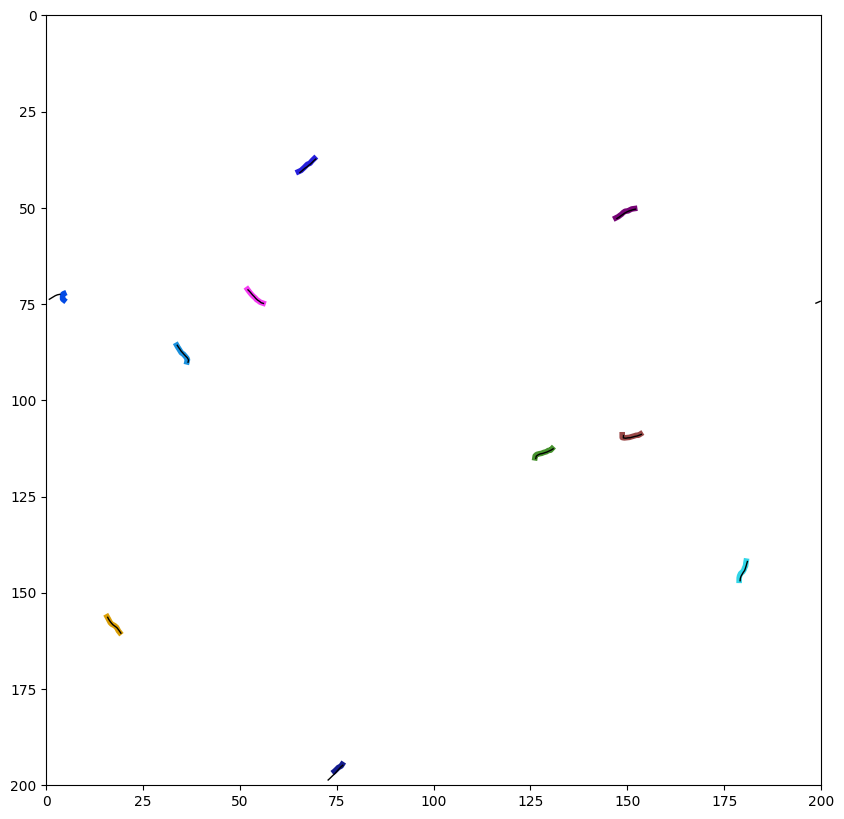

In [107]:
fig = plt.figure(figsize=(10, 10))

inde, _, _ = trajectory_assignment(trajs_gt_list, trajs_list_1, eps=5)
c=np.random.rand(len(inde[0]),3)

for  pair,c0 in zip(zip(inde[0],inde[1]),c):
     plt.plot(trajs_list_1[pair[1]][:,2] , trajs_list_1[pair[1]][:, 1] , color = c0, linewidth=4)
     # plt.scatter(trajs_list_1[pair[1]][-1, 2]  , trajs_list_1[pair[1]][-1, 1] , linewidths=1.5, color = c0) 
    
     plt.plot(trajs_gt_list[pair[0]][:,2] , trajs_gt_list[pair[0]][:, 1] , color = 'k', linewidth=1)
     # plt.scatter(trajs_gt_list[pair[0]][-1, 2]  , trajs_gt_list[pair[0]][-1, 1] , linewidths=1.5, color = 'k', marker = '+') 

# unpaired    
#FN
if len(trajs_gt_list)>len(inde[0]):
     complement = trajs_gt_list
     for i in inde[0]:
          complement = complement.pop(i)
     for co in complement:
           plt.plot(co[:,2] , co[:, 1] , color = 'green', linewidth=1)

#FP
if len(trajs_list_1)>len(inde[0]):
     complement = trajs_list_1
     for i in inde[1]:
          complement = complement.pop(i)
     for co in complement:
           plt.plot(co[:,2] , co[:, 1] , color = 'red', linewidth=1)

plt.xlim([0,200])
plt.ylim([200, 0])

##  Method 2: LAP (using laptrack version)
#### https://github.com/NoneqPhysLivingMatterLab/laptrack/tree/main
#### https://github.com/yfukai/laptrack/tree/main/docs/examples

In [108]:
from laptrack import LapTrack
max_distance = 5
lt = LapTrack(track_cost_cutoff=max_distance**2, gap_closing_max_frame_count=2)
t2, _, _ = lt.predict_dataframe(DF, ["y", "x"], only_coordinate_cols=True)
t2 = t2.reset_index()
t2.head()

/Users/841602/andi-metal/lib/python3.10/site-packages/laptrack/_tracking.py:778: FutureWarning: The parameter only_coordinate_cols will be False by default in the major release.
  warnings.warn(


,frame,index,y,x,tree_id,track_id
0,0,0,40.630302,65.093834,0,0
1,0,1,52.645401,147.007599,1,1
2,0,2,72.301361,4.586970,2,2
3,0,3,74.783165,56.018478,3,3
4,0,4,90.021950,36.348557,4,4


### make trajectory list from dataframe

In [109]:
trajs_list_2=[]

for i in t2.track_id.drop_duplicates() :
    _t = t2.loc[t2.track_id==i,['frame','y','x'] ].values
    trajs_list_2.append(_t )

### make and display video 

In [110]:
myvid = make_video_with_trajs(trajs_list_2, sim_movie)
play_video(myvid)

## evaluate trajectory metrics

In [111]:
_,_,_,_,_ = trajectory_metrics(trajs_gt_list, trajs_list_2, eps=5)


        TP: 11
        FP: 0
        FN: 0
        alpha: 0.9195227754655972
        beta: 0.9195227754655974


/var/folders/m1/pc2jmjl93c7chdf35rtyxdg0h6sh_6/T/ipykernel_37884/3510609749.py:10: RuntimeWarning: invalid value encountered in subtract
  d=np.sum((gt_f-pred_f)**2,axis=1)


## Method 3: MAGIK

### libraries

In [113]:
import deeptrack as dt
from deeptrack.models.gnns.generators import GraphGenerator

import tensorflow as tf

import pandas as pd
import numpy as np

import logging
logging.disable(logging.WARNING)

### simulate training dataset

In [115]:
df_training = []
df=[]
for _ivid in range(10):
    _trajs_training = simulate_Vicsek(n=10,N=30,dt=0.03,R=10,l=100,V=20)
    _trajs_list_training = traj_break(_trajs_training)
    for _i, _t in enumerate(_trajs_list_training):
        _df = pd.DataFrame(_t[:,1:], columns=["centroid-0", "centroid-1"])
        _df["frame"] = _t[:,0].astype(int)
        _df["label"] = _i
        _df["set"] = _ivid
        _df["solution"] = 0.0
        df.append(_df)
df_training = pd.concat(df, ignore_index=True) 

# normalize centroids between 0 and 1
df_training.loc[:, df_training.columns.str.contains("centroid")] = (
    df_training.loc[:, df_training.columns.str.contains("centroid")]
    / np.array([2.0*l, 2.0*l])
)

df_training.head()

,centroid-0,centroid-1,frame,label,set,solution
0,0.431334,0.331255,0,0,0,0.0
1,0.434097,0.330086,1,0,0,0.0
2,0.436955,0.329173,2,0,0,0.0
3,0.439841,0.328354,3,0,0,0.0
4,0.442547,0.327059,4,0,0,0.0


### define model

In [116]:
# Output type
_OUTPUT_TYPE = "edges"

# Seach radius for the graph edges
radius = 0.2

variables = dt.DummyFeature(
    radius=radius,
    output_type=_OUTPUT_TYPE,
    nofframes=3, # time window to associate nodes (in frames) 
)

model = dt.models.gnns.MAGIK(
    dense_layer_dimensions=(64, 96,),      # number of features in each dense encoder layer
    base_layer_dimensions=(96, 96, 96),    # Latent dimension throughout the message passing layers
    number_of_node_features=2,             # Number of node features in the graphs
    number_of_edge_features=1,             # Number of edge features in the graphs
    number_of_edge_outputs=1,              # Number of predicted features
    edge_output_activation="sigmoid",      # Activation function for the output layer
    output_type=_OUTPUT_TYPE,              # Output type. Either "edges", "nodes", or "graph"
)


# Compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss = 'binary_crossentropy',
    metrics=['accuracy'],
)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, 2)]    0           []                               
                                                                                                  
 node_ide1 (Dense)              (None, None, 64)     192         ['input_1[0][0]']                
                                                                                                  
 lambda (Lambda)                multiple             0           ['node_ide1[0][0]',              
                                                                  'edge_ide1[0][0]',              
                                                                  'node_ide2[0][0]',              
                                                                  'edge_ide2[0][0]',          

### load pretrained model or train a new one

In [117]:
_LOAD_MODEL = False

if _LOAD_MODEL:
    print("Loading model...")
    model.load_weights('./models/MAGIK.h5')
else:
    generator = GraphGenerator(
        nodesdf=df_training,
        properties=["centroid"],
        min_data_size=511,
        max_data_size=512,
        batch_size=8,
        **variables.properties() 
    )
    
    with generator:
        model.fit(generator, epochs=10)

    print("saving model...")
    os.makedirs("models/", exist_ok=True)
    model.save_weights("./models/MAGIK.h5")

Loading model...


### apply trained model to test data

In [129]:
# prepare dtaframe created by LodeSTAR
DF_m = DF.rename(columns = {"y":"centroid-0", "x":"centroid-1"})
DF_m["label"]=0
DF_m["set"]=0
DF_m["solution"]=0

# normalize centroids between 0 and 1
DF_m.loc[:, DF_m.columns.str.contains("centroid")] = (
    DF_m.loc[:, DF_m.columns.str.contains("centroid")]
    / np.array([2.0*l, 2.0*l])
)

# Get results
pred, gt, scores, graph = dt.models.gnns.get_predictions(DF_m, ["centroid"], model, **variables.properties())

# Crate dataframe from results
edges_df, nodes, _ = dt.models.gnns.df_from_results(pred, gt, scores, graph)

# Get trajectories from results
traj_out = dt.models.gnns.get_traj(edges_df, th = 4)

Creating graph edges...


  0%|          | 0/1 [00:00<?, ?it/s]/Users/841602/andi-metal/lib/python3.10/site-packages/deeptrack/models/gnns/graphs.py:62: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  dfs = [_df for _, _df in df]
/Users/841602/andi-metal/lib/python3.10/site-packages/deeptrack/models/gnns/graphs.py:62: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  dfs = [_df for _, _df in df]
/Users/841602/andi-metal/lib/python3.10/site-packages/deeptrack/models/gnns/graphs.py:62: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single group

### create trajectory list

In [130]:
trajs_list_3=[]

for i, (t, c) in enumerate(traj_out):
    n=nodes[t][:,0:]
    n[:,1:] *= 2.0*l
    trajs_list_3.append(n )#nodes[t][:,0:]#[nodes[t, 0], :])


### make and display video

In [131]:
myvid = make_video_with_trajs(trajs_list_3, sim_movie)
play_video(myvid)

### calculate metrics

In [132]:
_,_,_,_,_ = trajectory_metrics(trajs_gt_list, trajs_list_3, eps=5)


        TP: 10
        FP: 0
        FN: 1
        alpha: 0.942207907264132
        beta: 0.9422079072641321
